In [1]:
import torch
import torchvision
from torchsummary import summary
import warnings
# Suppress FutureWarning specifically from torch.load
warnings.filterwarnings("ignore", category=FutureWarning)
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

################### GPU ##########################

device = ("cuda" if torch.cuda.is_available() else "cpu")

if torch.backends.cudnn.is_available()==True:
    print('CUDNN is available! ')
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True

try:
    import torch_directml
    device = torch_directml.device()
    print("DirectML is available, using DirectML")
except:
    print("DirectML is not available, using CPU/GPU")

##################################################

import windturbine_final as wt

CUDNN is available! 
DirectML is not available, using CPU/GPU


In [ ]:
ResNet34 = torchvision.models.resnet34(weights=None)
ResNet34.fc = torch.nn.Linear(in_features=512,out_features=2,bias=True)
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet34.to(device)
# Print summary for a (3, 300, 300) input
summary(model, input_size=(3, 300, 300), device=device.type)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  36,864
|    |    └─BatchNorm2d: 3-7             128
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  36,864
|    |    └─BatchNorm2d: 3-10            128
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 36,864
|    |    └─BatchNorm2d: 3-12            128
|    |    └─ReLU: 3-13                   -

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  36,864
|    |    └─BatchNorm2d: 3-7             128
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  36,864
|    |    └─BatchNorm2d: 3-10            128
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 36,864
|    |    └─BatchNorm2d: 3-12            128
|    |    └─ReLU: 3-13                   -

In [ ]:
def transform(image):
    image = np.array(image)
    image = image[225:525,490:790]
    
    # Convert back to PIL Image for further transforms
    image = Image.fromarray(image)
    
    # Compose transformations
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert to tensor
    ])
    return transform(image)

def transform_all_noise(image):
    # Get either 0 or 1
    noise = np.random.randint(0, 2)
    if noise == 0:
        # Get 2 random numbers between -50 and 50
        x,y = np.random.randint(-50, 50, 2)

        # Convert image to array
        image = np.array(image)
        image = image[225+x:525+x,490+y:790+y]

        # Convert back to PIL Image for further transforms
        image = Image.fromarray(image)

        # Compose transformations
        transform = transforms.Compose([
            transforms.ToTensor(),  # Convert to tensor
        ])
    else:
        # Get a random number between 400 and 720
        x = np.random.randint(400, 720)
        transform = transforms.Compose([
            transforms.CenterCrop(x),
            transforms.Resize(300),
            transforms.ToTensor(),
        ])
    return transform(image)

def transform_uniform_noise(image):
    # Get 2 random numbers between -50 and 50
    x,y = np.random.normal(0, 15, 2).astype(int)

    # Convert image to array
    image = np.array(image)
    image = image[225+x:525+x,490+y:790+y]

    # Convert back to PIL Image for further transforms
    image = Image.fromarray(image)

    # Compose transformations
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert to tensor
    ])
    return transform(image)


### Parameters ResNet34

In [ ]:
angle_type = "both"
batch_size = 32
images_num = 1
base_angle_range = [0,360]
model = ResNet34
lr = 1e-2
epochs = 50
accu_th = [20,10,5]
model_name = "final_models/ResNet34_final.pth"

wind_dataset = wt.WindTurbineDataset(csv_file='rotations_w_images_long.csv', root_dir='data/', 
                                     images_num=images_num, transform=transform, angle_type=angle_type, base_angle_range=base_angle_range)
print(f"Dataset size: {len(wind_dataset)}")

train_dataset, test_dataset = wt.WindTurbineDataloader.train_test_split(wind_dataset, test_size=0.2)
trainloader = wt.WindTurbineDataloader.dataloader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = wt.WindTurbineDataloader.dataloader(test_dataset, batch_size=batch_size, shuffle=True)

try:
    model.load_state_dict(torch.load(model_name, map_location=torch.device("cpu")))
    print("Model loaded successfully")
    lr = 1e-4
except:
    print("Model not found, training from scratch")
model = model.to(device)

# Loss function
criterion = wt.modLoss(n_input=2)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#Scheduler
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=np.sqrt(0.1), patience=3, threshold=0.0001)

#Trainer
trainer = wt.Trainer(model, trainloader, testloader, criterion, optimizer,device, 
                     epochs=epochs, accu_th=accu_th, angle_type=angle_type, 
                     schedular=schedular, minimal=False)


Dataset size: 18000
Model not found, training from scratch


### ResNet34 Training

Epoch 1/40, Train Loss: 0.63, Test Loss: 0.637
lr [0.01]
Angle           20.00  10.00  5.0  20.00  10.00  5.00
Train Accuracy  11.04   5.59  2.9  34.51  17.59  8.90
Test Accuracy   12.25   5.97  2.9  32.91  16.45  7.55
Epoch 2/40, Train Loss: 0.62, Test Loss: 0.592
lr [0.01]
Angle           20.00  10.00  5.00  20.00  10.00   5.00
Train Accuracy  10.58   5.19  2.47  37.01  18.84   9.28
Test Accuracy   12.64   6.69  3.57  41.18  21.21  10.45
Epoch 3/40, Train Loss: 0.448, Test Loss: 0.499
lr [0.01]
Angle           20.00  10.00  5.00  20.00  10.00   5.00
Train Accuracy  20.92  10.76  5.35  52.59  28.96  14.95
Test Accuracy   19.44   9.93  4.87  40.51  21.38  10.73
Epoch 4/40, Train Loss: 0.268, Test Loss: 0.199
lr [0.01]
Angle           20.00  10.00   5.00  20.00  10.00   5.00
Train Accuracy  38.14  20.17  10.26  66.00  39.87  20.97
Test Accuracy   43.25  22.10  10.48  74.72  45.05  23.78
Epoch 5/40, Train Loss: 0.155, Test Loss: 0.105
lr [0.01]
Angle           20.00  10.00   5.00  20.00 

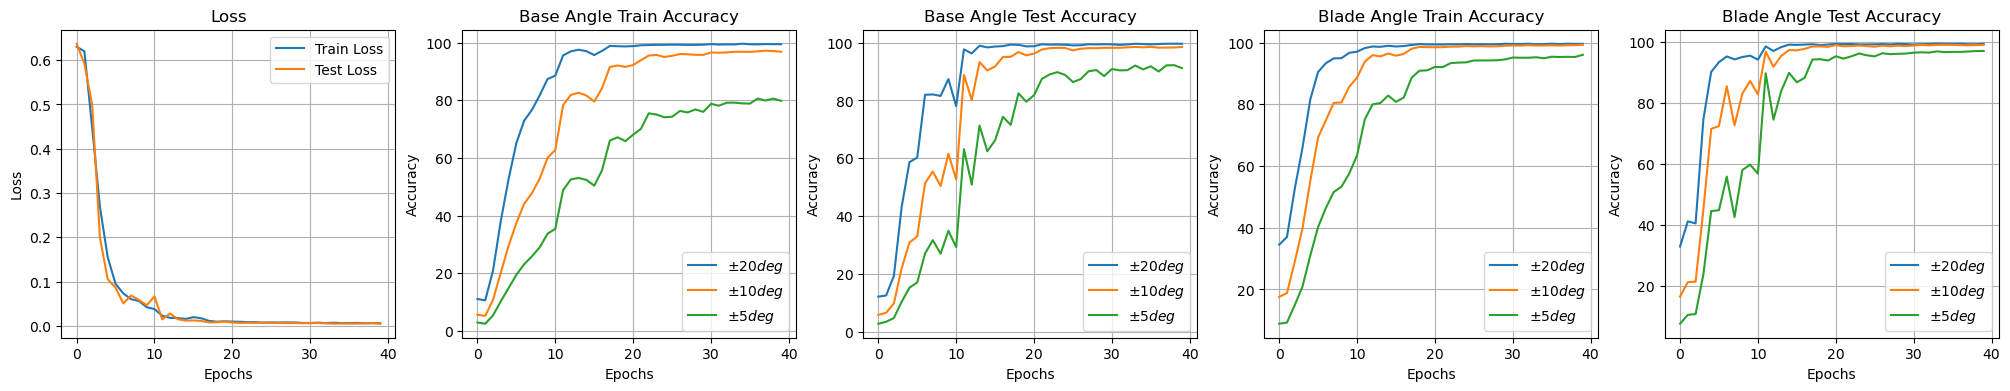

In [5]:
model = trainer.train_model()

# Plot the training and testing loss
plt.figure(figsize=(25, 4))
# Make subplot with loss and accuracy
plt.subplot(1, 5, 1)
plt.plot(trainer.train_loss, label="Train Loss")
plt.plot(trainer.test_loss, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")
plt.grid()
if not trainer.minimal:
    # Make subplot with loss and accuracy
    plt.subplot(1, 5, 2)
    plt.title("Base Angle Train Accuracy")
    plt.plot(trainer.train_accuracy[:,0], label=r"$\pm 20deg$")
    plt.plot(trainer.train_accuracy[:,1], label=r"$\pm 10deg$")
    plt.plot(trainer.train_accuracy[:,2], label=r"$\pm 5deg$")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()

    plt.subplot(1, 5, 3)
    plt.title("Base Angle Test Accuracy")
    plt.plot(trainer.test_accuracy[:,0], label=r"$\pm 20deg$")
    plt.plot(trainer.test_accuracy[:,1], label=r"$\pm 10deg$")
    plt.plot(trainer.test_accuracy[:,2], label=r"$\pm 5deg$")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()

    plt.subplot(1, 5, 4)
    plt.title("Blade Angle Train Accuracy")
    plt.plot(trainer.train_accuracy[:,3], label=r"$\pm 20deg$")
    plt.plot(trainer.train_accuracy[:,4], label=r"$\pm 10deg$")
    plt.plot(trainer.train_accuracy[:,5], label=r"$\pm 5deg$")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()

    plt.subplot(1, 5, 5)
    plt.title("Blade Angle Test Accuracy")
    plt.plot(trainer.test_accuracy[:,3], label=r"$\pm 20deg$")
    plt.plot(trainer.test_accuracy[:,4], label=r"$\pm 10deg$")
    plt.plot(trainer.test_accuracy[:,5], label=r"$\pm 5deg$")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
plt.show()

### Save Model

In [6]:
torch.save(model.to("cpu").state_dict(), model_name)
print("Model saved successfully")

Model saved successfully


### Test Model

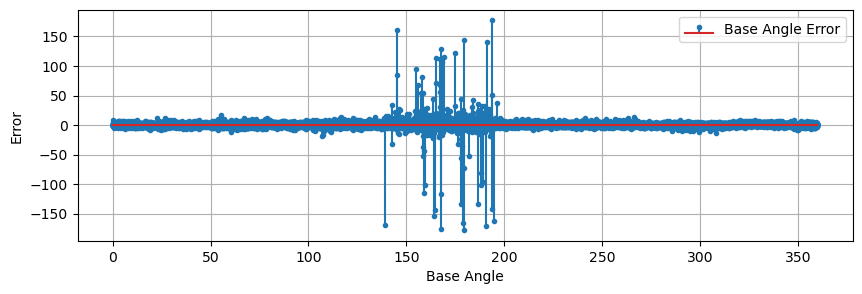

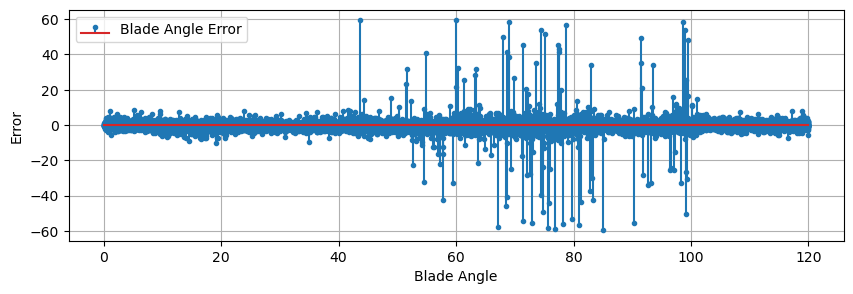

In [8]:
# # Test the model
results = trainer.test_model(model.to(device), wind_dataset, angle_type=angle_type)
# Sort the results by base angle
results_sorted = results.sort_values(by="Base_Angle")

# Plot the results
if angle_type == "both" or angle_type == "base_angle":
    plt.figure(figsize=(10, 3))
    plt.stem(results_sorted["Base_Angle"], results_sorted["Base_Angle_Error"], label="Base Angle Error",markerfmt='.')
    plt.xlabel("Base Angle")
    plt.ylabel("Error")
    plt.legend()
    plt.grid()
    plt.show()
if angle_type == "both" or angle_type == "blade_angle":
    plt.figure(figsize=(10, 3))
    plt.stem(results_sorted["Blade_Angle"], results_sorted["Blade_Angle_Error"], label="Blade Angle Error", markerfmt='.')
    plt.xlabel("Blade Angle")
    plt.ylabel("Error")
    plt.legend()
    plt.grid()
    plt.show()